Wilfredo Gallegos 20399


Paulo Sánchez 21401

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


c:\Users\raule\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
#Data Frame importaciones
dfi=pd.read_csv("ImportacionDS.csv",sep=";")
#Data frame consumo #Archivo consumo
dfc=pd.read_csv("ConsumoDS.csv",sep=";")
#Data Frame precios 
df_p=pd.read_csv("PreciosMensuales.csv",sep=";")
#Seleccionando las columnas por usar
df_imp=dfi[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_con=dfc[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_pre=df_p[["Fecha","Diesel","Gas licuado","Gasolina regular","Gasolina superior"]]


### Preparando la serie de tiempo para trabajar con ella desde del 2018 para los tres casos 

In [10]:
meses = {
    'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'
}

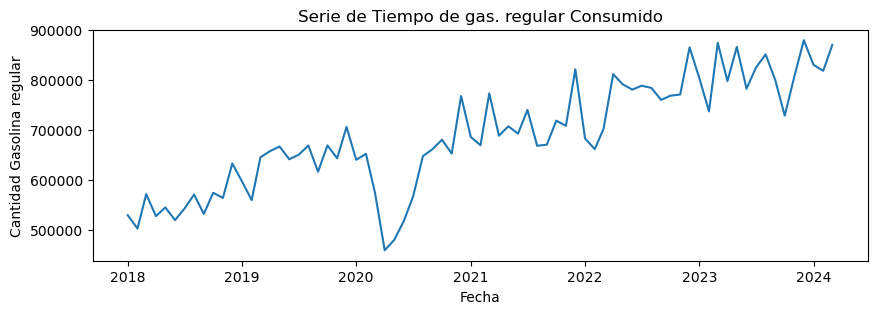

             Tipo      Valor      Fecha
0  Lectura Máxima  880233.12 2023-12-01
1  Lectura Mínima  458420.85 2020-04-01


In [11]:
# Crear una copia del DataFrame para trabajar con él
cons_regular = df_con[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
cons_regular['Fecha'] = cons_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
cons_regular['Fecha'] = pd.to_datetime(cons_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
cons_regular['Gasolina regular'] = cons_regular['Gasolina regular'].str.replace(',', '')
cons_regular['Gasolina regular'] = pd.to_numeric(cons_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
cons_regular = cons_regular.loc[cons_regular['Fecha'] >= start_date]
cons_regular = cons_regular.loc[cons_regular['Fecha'] <= end_date]

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(cons_regular['Fecha'], cons_regular['Gasolina regular'])
plt.title('Serie de Tiempo de gas. regular Consumido')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = cons_regular['Gasolina regular'].max()
min_value = cons_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = cons_regular[cons_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = cons_regular[cons_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)


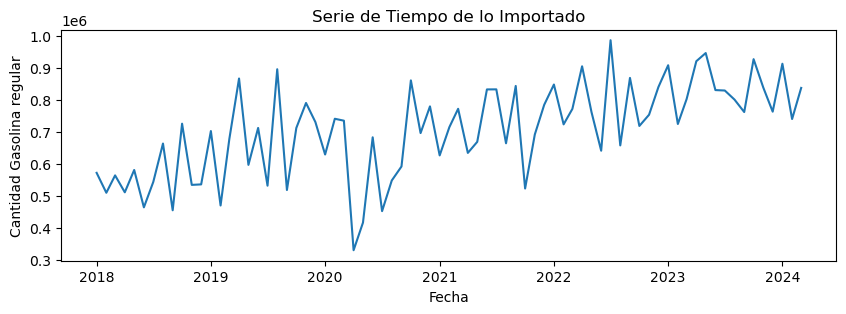

             Tipo      Valor      Fecha
0  Lectura Máxima  987872.05 2022-07-01
1  Lectura Mínima  329134.18 2020-04-01


In [12]:
 #Crear una copia del DataFrame para trabajar con él
imp_regular = df_imp[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
imp_regular['Fecha'] = imp_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
imp_regular['Fecha'] = pd.to_datetime(imp_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
imp_regular['Gasolina regular'] = imp_regular['Gasolina regular'].str.replace(',', '')
imp_regular['Gasolina regular'] = pd.to_numeric(imp_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
imp_regular = imp_regular.loc[imp_regular['Fecha'] >= start_date]
imp_regular = imp_regular.loc[imp_regular['Fecha'] <= end_date]

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(imp_regular['Fecha'], imp_regular['Gasolina regular'])
plt.title('Serie de Tiempo de lo Importado')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = imp_regular['Gasolina regular'].max()
min_value = imp_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = imp_regular[imp_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = imp_regular[imp_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

             Tipo  Valor      Fecha
0  Lectura Máxima  40.16 2022-06-01
1  Lectura Mínima  17.71 2020-05-01


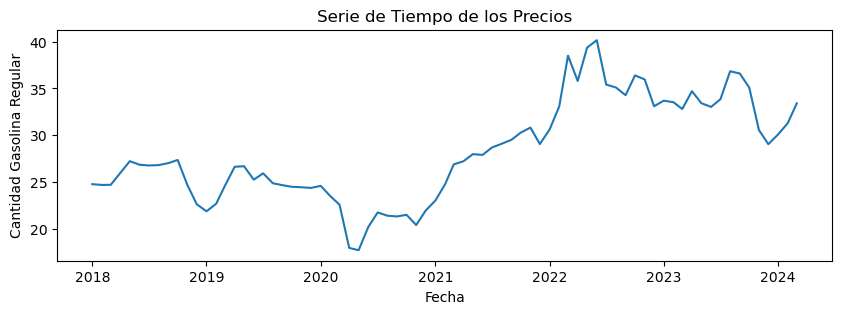

In [13]:
# Crear una copia del DataFrame para trabajar con él
pre_regular = df_pre[['Fecha', 'Gasolina regular']].copy()

pre_regular['Fecha'] = pre_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime con el formato 'mm-yy'
pre_regular['Fecha'] = pd.to_datetime(pre_regular['Fecha'], format='%m-%y')

start_date = '2018-01-01'
end_date = '2024-03-01'
pre_regular = pre_regular.loc[pre_regular['Fecha'] >= start_date]
pre_regular = pre_regular.loc[pre_regular['Fecha'] <= end_date]

plt.figure(figsize=(10, 3))
plt.plot(pre_regular["Fecha"], pre_regular["Gasolina regular"])
plt.title('Serie de Tiempo de los Precios')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina Regular')
# plt.grid(True)

# Encontrar el valor máximo y mínimo
max_value = pre_regular['Gasolina regular'].max()
min_value = pre_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = pre_regular[pre_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = pre_regular[pre_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

Para mantener estacionalidad se transformo el precio de la Gasolina Regular para que se acoplara y mantuviera la varianza constante para los modelos. 

In [14]:
pre_regular['Gasolina regular'] = np.log(pre_regular['Gasolina regular'] + 1)

## Modelo LSTM

### Consumo Gasolina Regular 